# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 60% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [7]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [104]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  10.002986221180933
Mean of train-time output:  23.32523578017055
Mean of test-time output:  10.002986221180933
Fraction of train-time output set to zero:  0.300468
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.002986221180933
Mean of train-time output:  6.65698313532431
Mean of test-time output:  10.002986221180933
Fraction of train-time output set to zero:  0.600784
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.002986221180933
Mean of train-time output:  3.333122453911115
Mean of test-time output:  10.002986221180933
Fraction of train-time output set to zero:  0.750104
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [103]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445602445737837e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [119]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0
Initial loss:  2.303043161170242
W1 relative error: 4.795196815215288e-07
W2 relative error: 1.9717710574314515e-07
W3 relative error: 1.5587099483501822e-07
b1 relative error: 2.033615448560775e-08
b2 relative error: 1.686315567518667e-09
b3 relative error: 1.1144421861081857e-10


Running check with dropout =  0.25
Initial loss:  2.3330140372768184
W1 relative error: 9.253341687730495e-08
W2 relative error: 2.5446280167944563e-08
W3 relative error: 2.5878037400827446e-08
b1 relative error: 3.7793905405960475e-10
b2 relative error: 4.179268976061755e-09
b3 relative error: 1.3965346166138227e-10


Running check with dropout =  0.5
Initial loss:  2.2994400290646637
W1 relative error: 3.38841535237639e-08
W2 relative error: 8.884395587455194e-08
W3 relative error: 2.3767592670693847e-08
b1 relative error: 9.935222529879073e-10
b2 relative error: 8.032917281149487e-10
b3 relative error: 1.4333807510530193e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [120]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

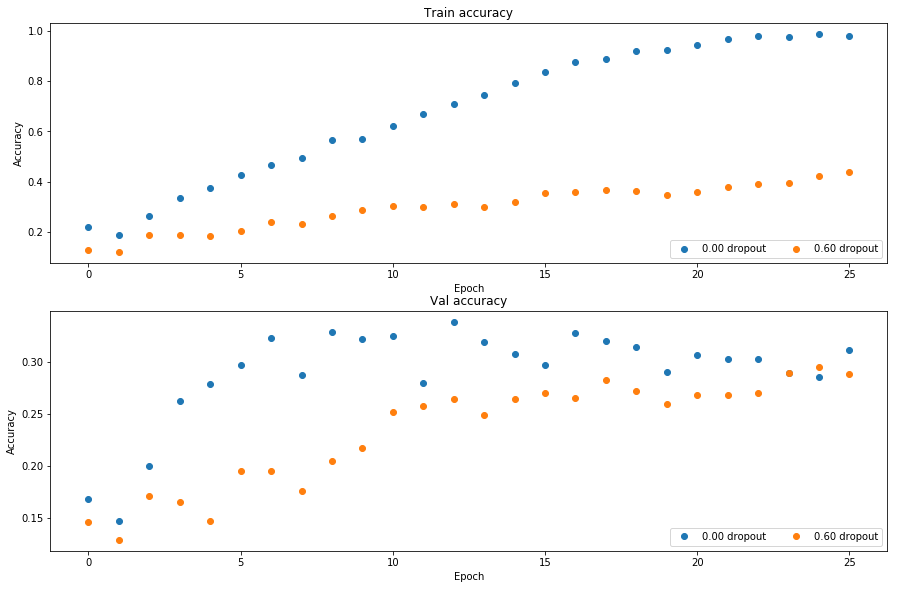

In [121]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:

Yes, dropout is performing regularization. As shown in the validation accuracy, even though without dropout and with dropout have different growing rate, they end up have the similar validation accuracy. Thus, dropout performs regularization.

## Final part of the assignment

Get over 60% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 28%, 1) 
where if you get 60% or higher validation accuracy, you get full points.

In [14]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 60% validation accuracy
#   on CIFAR-10.
# ================================================================ #
hidden_dims = [512, 256, 128,128]
best_model = FullyConnectedNet(hidden_dims, weight_scale=1e-1, dropout=0.25, use_batchnorm=True, reg = 0)

best_solver = Solver(best_model, data,
                num_epochs=20, batch_size=1000,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay = 0.95,
                verbose=True, print_every=100)
best_solver.train()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 980) loss: 4.464784
(Epoch 0 / 20) train acc: 0.142000; val_acc: 0.157000
(Epoch 1 / 20) train acc: 0.378000; val_acc: 0.357000
(Epoch 2 / 20) train acc: 0.398000; val_acc: 0.389000
(Iteration 101 / 980) loss: 2.082298
(Epoch 3 / 20) train acc: 0.409000; val_acc: 0.427000
(Epoch 4 / 20) train acc: 0.467000; val_acc: 0.435000
(Iteration 201 / 980) loss: 1.828813
(Epoch 5 / 20) train acc: 0.467000; val_acc: 0.456000
(Epoch 6 / 20) train acc: 0.472000; val_acc: 0.455000
(Iteration 301 / 980) loss: 1.606175
(Epoch 7 / 20) train acc: 0.484000; val_acc: 0.469000
(Epoch 8 / 20) train acc: 0.521000; val_acc: 0.475000
(Iteration 401 / 980) loss: 1.574865
(Epoch 9 / 20) train acc: 0.517000; val_acc: 0.492000
(Epoch 10 / 20) train acc: 0.537000; val_acc: 0.497000
(Iteration 501 / 980) loss: 1.417194
(Epoch 11 / 20) train acc: 0.550000; val_acc: 0.497000
(Epoch 12 / 20) train acc: 0.564000; val_acc: 0.509000
(Iteration 601 / 980) loss: 1.494064
(Epoch 13 / 20) train acc: 0.565000; v

In [16]:
#not good enough
hidden_dims = [512, 256, 128,128]
best_model_2 = FullyConnectedNet(hidden_dims, weight_scale=5e-4, dropout=0.25, use_batchnorm=True, reg = 0)

best_solver_2 = Solver(best_model_2, data,
                num_epochs=20, batch_size=500,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay = 0.9,
                verbose=True, print_every=100)
best_solver_2.train()

(Iteration 1 / 1960) loss: 2.302855
(Epoch 0 / 20) train acc: 0.112000; val_acc: 0.096000
(Epoch 1 / 20) train acc: 0.437000; val_acc: 0.435000
(Iteration 101 / 1960) loss: 1.602322
(Epoch 2 / 20) train acc: 0.467000; val_acc: 0.468000
(Iteration 201 / 1960) loss: 1.492580
(Epoch 3 / 20) train acc: 0.533000; val_acc: 0.494000
(Iteration 301 / 1960) loss: 1.394663
(Epoch 4 / 20) train acc: 0.533000; val_acc: 0.526000
(Iteration 401 / 1960) loss: 1.422451
(Epoch 5 / 20) train acc: 0.555000; val_acc: 0.530000
(Iteration 501 / 1960) loss: 1.288689
(Epoch 6 / 20) train acc: 0.604000; val_acc: 0.537000
(Iteration 601 / 1960) loss: 1.236507
(Epoch 7 / 20) train acc: 0.608000; val_acc: 0.539000
(Iteration 701 / 1960) loss: 1.177612
(Epoch 8 / 20) train acc: 0.620000; val_acc: 0.549000
(Iteration 801 / 1960) loss: 1.176849
(Epoch 9 / 20) train acc: 0.657000; val_acc: 0.560000
(Iteration 901 / 1960) loss: 1.191805
(Epoch 10 / 20) train acc: 0.653000; val_acc: 0.561000
(Iteration 1001 / 1960) los

In [17]:
#better but not enough
hidden_dims = [512, 256, 128,128]
best_model_3 = FullyConnectedNet(hidden_dims, weight_scale=5e-4, dropout=0.25, use_batchnorm=True, reg = 0)

best_solver_3 = Solver(best_model_3, data,
                num_epochs=20, batch_size=500,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay = 0.95,
                verbose=True, print_every=100)
best_solver_3.train()

(Iteration 1 / 1960) loss: 2.302936
(Epoch 0 / 20) train acc: 0.104000; val_acc: 0.082000
(Epoch 1 / 20) train acc: 0.422000; val_acc: 0.446000
(Iteration 101 / 1960) loss: 1.620973
(Epoch 2 / 20) train acc: 0.508000; val_acc: 0.484000
(Iteration 201 / 1960) loss: 1.465264
(Epoch 3 / 20) train acc: 0.522000; val_acc: 0.489000
(Iteration 301 / 1960) loss: 1.422866
(Epoch 4 / 20) train acc: 0.563000; val_acc: 0.524000
(Iteration 401 / 1960) loss: 1.318526
(Epoch 5 / 20) train acc: 0.558000; val_acc: 0.531000
(Iteration 501 / 1960) loss: 1.364456
(Epoch 6 / 20) train acc: 0.552000; val_acc: 0.531000
(Iteration 601 / 1960) loss: 1.212908
(Epoch 7 / 20) train acc: 0.603000; val_acc: 0.559000
(Iteration 701 / 1960) loss: 1.317531
(Epoch 8 / 20) train acc: 0.580000; val_acc: 0.557000
(Iteration 801 / 1960) loss: 1.124024
(Epoch 9 / 20) train acc: 0.622000; val_acc: 0.552000
(Iteration 901 / 1960) loss: 1.191352
(Epoch 10 / 20) train acc: 0.633000; val_acc: 0.557000
(Iteration 1001 / 1960) los

In [8]:
hidden_dims = [512, 256, 128,128]
best_model_4 = FullyConnectedNet(hidden_dims, weight_scale=4e-4, dropout=0.25, use_batchnorm=True, reg = 0)

best_solver_4 = Solver(best_model_4, data,
                num_epochs=20, batch_size=800,
                update_rule='adam',
                optim_config={
                  'learning_rate': 5e-4,
                },
                lr_decay = 0.95,
                verbose=True, print_every=100)
best_solver_4.train()

(Iteration 1 / 1220) loss: 2.302937
(Epoch 0 / 20) train acc: 0.093000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.408000; val_acc: 0.424000
(Iteration 101 / 1220) loss: 1.581968
(Epoch 2 / 20) train acc: 0.470000; val_acc: 0.475000
(Epoch 3 / 20) train acc: 0.479000; val_acc: 0.506000
(Iteration 201 / 1220) loss: 1.415818
(Epoch 4 / 20) train acc: 0.554000; val_acc: 0.521000
(Iteration 301 / 1220) loss: 1.355686
(Epoch 5 / 20) train acc: 0.553000; val_acc: 0.533000
(Epoch 6 / 20) train acc: 0.563000; val_acc: 0.525000
(Iteration 401 / 1220) loss: 1.297995
(Epoch 7 / 20) train acc: 0.582000; val_acc: 0.528000
(Epoch 8 / 20) train acc: 0.606000; val_acc: 0.539000
(Iteration 501 / 1220) loss: 1.242966
(Epoch 9 / 20) train acc: 0.617000; val_acc: 0.560000
(Iteration 601 / 1220) loss: 1.171577
(Epoch 10 / 20) train acc: 0.608000; val_acc: 0.557000
(Epoch 11 / 20) train acc: 0.630000; val_acc: 0.562000
(Iteration 701 / 1220) loss: 1.121752
(Epoch 12 / 20) train acc: 0.655000; val_acc: 0.

In [9]:
best_solver_4.optim_config = {'learning_rate':1e-5}
best_solver_4.train()

(Iteration 1 / 1220) loss: 0.910040
(Epoch 20 / 20) train acc: 0.682000; val_acc: 0.587000
(Epoch 21 / 20) train acc: 0.709000; val_acc: 0.571000
(Iteration 101 / 1220) loss: 1.004231
(Epoch 22 / 20) train acc: 0.712000; val_acc: 0.580000
(Epoch 23 / 20) train acc: 0.726000; val_acc: 0.577000
(Iteration 201 / 1220) loss: 0.987588
(Epoch 24 / 20) train acc: 0.735000; val_acc: 0.570000
(Iteration 301 / 1220) loss: 0.937163
(Epoch 25 / 20) train acc: 0.712000; val_acc: 0.574000
(Epoch 26 / 20) train acc: 0.754000; val_acc: 0.580000
(Iteration 401 / 1220) loss: 0.862374
(Epoch 27 / 20) train acc: 0.755000; val_acc: 0.582000
(Epoch 28 / 20) train acc: 0.715000; val_acc: 0.575000
(Iteration 501 / 1220) loss: 0.949683
(Epoch 29 / 20) train acc: 0.754000; val_acc: 0.575000
(Iteration 601 / 1220) loss: 0.895649
(Epoch 30 / 20) train acc: 0.754000; val_acc: 0.589000
(Epoch 31 / 20) train acc: 0.743000; val_acc: 0.584000
(Iteration 701 / 1220) loss: 0.866104
(Epoch 32 / 20) train acc: 0.760000; v

In [12]:
#try harder and harder but not enough
best_solver_4.optim_config = {'learning_rate':1e-5}
best_solver_4.train()

(Iteration 1 / 1220) loss: 0.757553
(Epoch 78 / 20) train acc: 0.807000; val_acc: 0.588000
(Epoch 79 / 20) train acc: 0.825000; val_acc: 0.597000
(Iteration 101 / 1220) loss: 0.788459
(Epoch 80 / 20) train acc: 0.832000; val_acc: 0.598000
(Epoch 81 / 20) train acc: 0.827000; val_acc: 0.599000
(Iteration 201 / 1220) loss: 0.767055
(Epoch 82 / 20) train acc: 0.801000; val_acc: 0.595000
(Iteration 301 / 1220) loss: 0.772615
(Epoch 83 / 20) train acc: 0.823000; val_acc: 0.595000
(Epoch 84 / 20) train acc: 0.809000; val_acc: 0.603000
(Iteration 401 / 1220) loss: 0.815962
(Epoch 85 / 20) train acc: 0.795000; val_acc: 0.597000
(Epoch 86 / 20) train acc: 0.807000; val_acc: 0.597000
(Iteration 501 / 1220) loss: 0.722797
(Epoch 87 / 20) train acc: 0.835000; val_acc: 0.597000
(Iteration 601 / 1220) loss: 0.784276
(Epoch 88 / 20) train acc: 0.830000; val_acc: 0.598000
(Epoch 89 / 20) train acc: 0.836000; val_acc: 0.593000
(Iteration 701 / 1220) loss: 0.786817
(Epoch 90 / 20) train acc: 0.802000; v

In [21]:
#start a new one
hidden_dims = [512, 256, 128,128]
best_model_5 = FullyConnectedNet(hidden_dims, weight_scale=3.6e-4, dropout=0.25, use_batchnorm=True, reg = 0)

best_solver_5 = Solver(best_model_5, data,
                num_epochs=25, batch_size=800,
                update_rule='adam',
                optim_config={
                  'learning_rate': 3e-4,
                },
                lr_decay = 1,
                verbose=True, print_every=100)
best_solver_5.train()

(Iteration 1 / 1525) loss: 2.302562
(Epoch 0 / 25) train acc: 0.138000; val_acc: 0.131000
(Epoch 1 / 25) train acc: 0.388000; val_acc: 0.407000
(Iteration 101 / 1525) loss: 1.601654
(Epoch 2 / 25) train acc: 0.509000; val_acc: 0.470000
(Epoch 3 / 25) train acc: 0.499000; val_acc: 0.501000
(Iteration 201 / 1525) loss: 1.491903
(Epoch 4 / 25) train acc: 0.525000; val_acc: 0.517000
(Iteration 301 / 1525) loss: 1.385780
(Epoch 5 / 25) train acc: 0.540000; val_acc: 0.536000
(Epoch 6 / 25) train acc: 0.561000; val_acc: 0.531000
(Iteration 401 / 1525) loss: 1.316985
(Epoch 7 / 25) train acc: 0.589000; val_acc: 0.529000
(Epoch 8 / 25) train acc: 0.573000; val_acc: 0.550000
(Iteration 501 / 1525) loss: 1.294200
(Epoch 9 / 25) train acc: 0.602000; val_acc: 0.548000
(Iteration 601 / 1525) loss: 1.256723
(Epoch 10 / 25) train acc: 0.629000; val_acc: 0.567000
(Epoch 11 / 25) train acc: 0.640000; val_acc: 0.557000
(Iteration 701 / 1525) loss: 1.150091
(Epoch 12 / 25) train acc: 0.621000; val_acc: 0.

In [22]:
best_solver_5.optim_config = {'learning_rate':1e-4}
best_solver_5.lr_decay = 0.9
best_solver_5.train()

(Iteration 1 / 1525) loss: 0.985593
(Epoch 25 / 25) train acc: 0.724000; val_acc: 0.577000
(Epoch 26 / 25) train acc: 0.724000; val_acc: 0.584000
(Iteration 101 / 1525) loss: 0.910875
(Epoch 27 / 25) train acc: 0.736000; val_acc: 0.577000
(Epoch 28 / 25) train acc: 0.755000; val_acc: 0.578000
(Iteration 201 / 1525) loss: 0.907296
(Epoch 29 / 25) train acc: 0.736000; val_acc: 0.584000
(Iteration 301 / 1525) loss: 0.843325
(Epoch 30 / 25) train acc: 0.780000; val_acc: 0.574000
(Epoch 31 / 25) train acc: 0.779000; val_acc: 0.592000
(Iteration 401 / 1525) loss: 0.799160
(Epoch 32 / 25) train acc: 0.766000; val_acc: 0.584000
(Epoch 33 / 25) train acc: 0.796000; val_acc: 0.578000
(Iteration 501 / 1525) loss: 0.816030
(Epoch 34 / 25) train acc: 0.780000; val_acc: 0.580000
(Iteration 601 / 1525) loss: 0.787711
(Epoch 35 / 25) train acc: 0.792000; val_acc: 0.556000
(Epoch 36 / 25) train acc: 0.799000; val_acc: 0.583000
(Iteration 701 / 1525) loss: 0.785799
(Epoch 37 / 25) train acc: 0.808000; v

In [23]:
best_solver_5.optim_config = {'learning_rate':1e-5}
best_solver_5.lr_decay = 0.9
best_solver_5.train()

(Iteration 1 / 1525) loss: 0.747159
(Epoch 50 / 25) train acc: 0.816000; val_acc: 0.599000
(Epoch 51 / 25) train acc: 0.823000; val_acc: 0.590000
(Iteration 101 / 1525) loss: 0.738318
(Epoch 52 / 25) train acc: 0.811000; val_acc: 0.589000
(Epoch 53 / 25) train acc: 0.811000; val_acc: 0.587000
(Iteration 201 / 1525) loss: 0.705836
(Epoch 54 / 25) train acc: 0.829000; val_acc: 0.584000
(Iteration 301 / 1525) loss: 0.733600
(Epoch 55 / 25) train acc: 0.819000; val_acc: 0.594000
(Epoch 56 / 25) train acc: 0.832000; val_acc: 0.585000
(Iteration 401 / 1525) loss: 0.706051
(Epoch 57 / 25) train acc: 0.835000; val_acc: 0.593000
(Epoch 58 / 25) train acc: 0.805000; val_acc: 0.587000
(Iteration 501 / 1525) loss: 0.702104
(Epoch 59 / 25) train acc: 0.815000; val_acc: 0.595000
(Iteration 601 / 1525) loss: 0.731486
(Epoch 60 / 25) train acc: 0.835000; val_acc: 0.589000
(Epoch 61 / 25) train acc: 0.849000; val_acc: 0.591000
(Iteration 701 / 1525) loss: 0.662451
(Epoch 62 / 25) train acc: 0.844000; v

In [24]:
best_solver_5.optim_config = {'learning_rate':1e-5}
best_solver_5.lr_decay = 0.95
best_solver_5.train()

(Iteration 1 / 1525) loss: 0.758629
(Epoch 75 / 25) train acc: 0.818000; val_acc: 0.599000
(Epoch 76 / 25) train acc: 0.810000; val_acc: 0.598000
(Iteration 101 / 1525) loss: 0.735850
(Epoch 77 / 25) train acc: 0.834000; val_acc: 0.594000
(Epoch 78 / 25) train acc: 0.824000; val_acc: 0.594000
(Iteration 201 / 1525) loss: 0.747949
(Epoch 79 / 25) train acc: 0.809000; val_acc: 0.597000
(Iteration 301 / 1525) loss: 0.760584
(Epoch 80 / 25) train acc: 0.816000; val_acc: 0.599000
(Epoch 81 / 25) train acc: 0.809000; val_acc: 0.597000
(Iteration 401 / 1525) loss: 0.762652
(Epoch 82 / 25) train acc: 0.818000; val_acc: 0.597000
(Epoch 83 / 25) train acc: 0.814000; val_acc: 0.596000
(Iteration 501 / 1525) loss: 0.806407
(Epoch 84 / 25) train acc: 0.824000; val_acc: 0.598000
(Iteration 601 / 1525) loss: 0.771218
(Epoch 85 / 25) train acc: 0.829000; val_acc: 0.599000
(Epoch 86 / 25) train acc: 0.806000; val_acc: 0.597000
(Iteration 701 / 1525) loss: 0.744495
(Epoch 87 / 25) train acc: 0.810000; v

In [25]:
#finally !!!!!
best_solver_5.optim_config = {'learning_rate':2e-5}
best_solver_5.lr_decay = 0.9
best_solver_5.train()

(Iteration 1 / 1525) loss: 0.783917
(Epoch 100 / 25) train acc: 0.827000; val_acc: 0.601000
(Epoch 101 / 25) train acc: 0.836000; val_acc: 0.602000
(Iteration 101 / 1525) loss: 0.787694
(Epoch 102 / 25) train acc: 0.824000; val_acc: 0.602000
(Epoch 103 / 25) train acc: 0.833000; val_acc: 0.601000
(Iteration 201 / 1525) loss: 0.746222
(Epoch 104 / 25) train acc: 0.839000; val_acc: 0.600000
(Iteration 301 / 1525) loss: 0.799186
(Epoch 105 / 25) train acc: 0.811000; val_acc: 0.601000
(Epoch 106 / 25) train acc: 0.822000; val_acc: 0.601000
(Iteration 401 / 1525) loss: 0.748683
(Epoch 107 / 25) train acc: 0.827000; val_acc: 0.601000
(Epoch 108 / 25) train acc: 0.809000; val_acc: 0.600000
(Iteration 501 / 1525) loss: 0.759193
(Epoch 109 / 25) train acc: 0.837000; val_acc: 0.599000
(Iteration 601 / 1525) loss: 0.892576
(Epoch 110 / 25) train acc: 0.836000; val_acc: 0.600000
(Epoch 111 / 25) train acc: 0.854000; val_acc: 0.600000
(Iteration 701 / 1525) loss: 0.729043
(Epoch 112 / 25) train acc

In [ ]:
final_best_model = best_model_5

In [15]:
#furthur:
hidden_dims = [512, 256, 128,128]
best_model_t = FullyConnectedNet(hidden_dims, weight_scale=5e-4, dropout=0.25, use_batchnorm=True, reg = 0.01)

best_solver_t = Solver(best_model_t, data,
                num_epochs=40, batch_size=500,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay = 0.95,
                verbose=True, print_every=100)
best_solver_t.train()

(Iteration 1 / 3920) loss: 2.303538
(Epoch 0 / 40) train acc: 0.091000; val_acc: 0.099000
(Epoch 1 / 40) train acc: 0.417000; val_acc: 0.433000
(Iteration 101 / 3920) loss: 1.930468
(Epoch 2 / 40) train acc: 0.434000; val_acc: 0.440000
(Iteration 201 / 3920) loss: 1.774290
(Epoch 3 / 40) train acc: 0.449000; val_acc: 0.479000
(Iteration 301 / 3920) loss: 1.831612
(Epoch 4 / 40) train acc: 0.470000; val_acc: 0.476000
(Iteration 401 / 3920) loss: 1.770238
(Epoch 5 / 40) train acc: 0.476000; val_acc: 0.465000
(Iteration 501 / 3920) loss: 1.761944
(Epoch 6 / 40) train acc: 0.493000; val_acc: 0.483000
(Iteration 601 / 3920) loss: 1.784505
(Epoch 7 / 40) train acc: 0.482000; val_acc: 0.492000
(Iteration 701 / 3920) loss: 1.799319
(Epoch 8 / 40) train acc: 0.479000; val_acc: 0.506000
(Iteration 801 / 3920) loss: 1.753869
(Epoch 9 / 40) train acc: 0.481000; val_acc: 0.483000
(Iteration 901 / 3920) loss: 1.746176
(Epoch 10 / 40) train acc: 0.486000; val_acc: 0.486000
(Iteration 1001 / 3920) los

In [16]:
best_solver_t.optim_config = {'learning_rate':2e-5}
best_solver_t.lr_decay = 0.9
best_solver_t.train()

(Iteration 1 / 3920) loss: 1.324132
(Epoch 40 / 40) train acc: 0.636000; val_acc: 0.580000
(Epoch 41 / 40) train acc: 0.680000; val_acc: 0.567000
(Iteration 101 / 3920) loss: 1.273536
(Epoch 42 / 40) train acc: 0.631000; val_acc: 0.565000
(Iteration 201 / 3920) loss: 1.298206
(Epoch 43 / 40) train acc: 0.702000; val_acc: 0.599000
(Iteration 301 / 3920) loss: 1.349385
(Epoch 44 / 40) train acc: 0.654000; val_acc: 0.558000
(Iteration 401 / 3920) loss: 1.201165
(Epoch 45 / 40) train acc: 0.677000; val_acc: 0.582000
(Iteration 501 / 3920) loss: 1.208417
(Epoch 46 / 40) train acc: 0.688000; val_acc: 0.584000
(Iteration 601 / 3920) loss: 1.257699
(Epoch 47 / 40) train acc: 0.695000; val_acc: 0.583000
(Iteration 701 / 3920) loss: 1.205091
(Epoch 48 / 40) train acc: 0.699000; val_acc: 0.610000
(Iteration 801 / 3920) loss: 1.151211
(Epoch 49 / 40) train acc: 0.701000; val_acc: 0.594000
(Iteration 901 / 3920) loss: 1.178737
(Epoch 50 / 40) train acc: 0.719000; val_acc: 0.581000
(Iteration 1001 /

In [18]:
best_solver_t.optim_config = {'learning_rate':2e-5}
best_solver_t.lr_decay = 0.9
best_solver_t.train()

(Iteration 1 / 3920) loss: 1.090858
(Epoch 80 / 40) train acc: 0.698000; val_acc: 0.610000
(Epoch 81 / 40) train acc: 0.743000; val_acc: 0.598000
(Iteration 101 / 3920) loss: 1.112483
(Epoch 82 / 40) train acc: 0.720000; val_acc: 0.594000
(Iteration 201 / 3920) loss: 1.132184
(Epoch 83 / 40) train acc: 0.735000; val_acc: 0.593000
(Iteration 301 / 3920) loss: 1.082293
(Epoch 84 / 40) train acc: 0.730000; val_acc: 0.598000
(Iteration 401 / 3920) loss: 1.227742
(Epoch 85 / 40) train acc: 0.716000; val_acc: 0.599000
(Iteration 501 / 3920) loss: 1.177000
(Epoch 86 / 40) train acc: 0.733000; val_acc: 0.599000
(Iteration 601 / 3920) loss: 1.172990
(Epoch 87 / 40) train acc: 0.741000; val_acc: 0.599000
(Iteration 701 / 3920) loss: 1.051439
(Epoch 88 / 40) train acc: 0.718000; val_acc: 0.602000
(Iteration 801 / 3920) loss: 1.155060
(Epoch 89 / 40) train acc: 0.734000; val_acc: 0.602000
(Iteration 901 / 3920) loss: 1.143017
(Epoch 90 / 40) train acc: 0.730000; val_acc: 0.605000
(Iteration 1001 /

In [19]:
y_test_pred = np.argmax(best_model_t.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model_t .loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))

Validation set accuracy: 0.616
Test set accuracy: 0.605
